In [9]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten, BatchNormalization, Dropout, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16


from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split


In [10]:
# Load the augmented data from the saved file
data = np.load('../data/external/coral_augmented_combined_vgg16.npz')

# Access the arrays from the loaded data
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']

# Check the shape of the loaded data
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5104, 224, 224, 3)
y_train shape: (5104,)
X_test shape: (1276, 224, 224, 3)
y_test shape: (1276,)


In [11]:
# Split your training data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# X_train and y_train are now your training data, X_valid and y_valid are your validation data,
# and X_test and y_test are your testing data

# Print the shapes to verify
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (4083, 224, 224, 3)
y_train shape: (4083,)
X_valid shape: (1021, 224, 224, 3)
y_valid shape: (1021,)
X_test shape: (1276, 224, 224, 3)
y_test shape: (1276,)


In [12]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels in both training and test sets
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_valid_encoded = label_encoder.transform(y_valid)

# Convert the encoded labels to one-hot encoded format
num_classes = len(label_encoder.classes_)
y_train_onehot = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_onehot = to_categorical(y_test_encoded, num_classes=num_classes)
y_valid_onehot = to_categorical(y_valid_encoded, num_classes=num_classes)

In [13]:

# Load the VGG16 model pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add your own fully connected layers for classification
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)  # Add your desired number of neurons
output = Dense(num_classes, activation='softmax')(x)  # num_classes is the number of classes in your data

# Create a new model with your layers on top of the VGG16 base
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# You can choose a different optimizer and loss function depending on your specific problem.

# Now, you can train your model using your augmented and normalized data
history = model.fit(X_train, y_train_onehot, validation_data=(X_valid, y_valid_onehot), epochs=10, batch_size=32)  # You can adjust the number of epochs and batch size



Epoch 1/10
128/128 [==============================] - 645s 5s/step - loss: 1.6957 - accuracy: 0.9633 - val_loss: 0.0721 - val_accuracy: 0.9902
Epoch 2/10
128/128 [==============================] - 667s 5s/step - loss: 0.0610 - accuracy: 0.9958 - val_loss: 0.0062 - val_accuracy: 0.9990
Epoch 3/10
128/128 [==============================] - 663s 5s/step - loss: 0.0165 - accuracy: 0.9973 - val_loss: 0.0040 - val_accuracy: 0.9990
Epoch 4/10
128/128 [==============================] - 664s 5s/step - loss: 0.0193 - accuracy: 0.9983 - val_loss: 0.0338 - val_accuracy: 0.9990
Epoch 5/10
128/128 [==============================] - 660s 5s/step - loss: 0.0560 - accuracy: 0.9973 - val_loss: 0.1282 - val_accuracy: 0.9922
Epoch 6/10
128/128 [==============================] - 660s 5s/step - loss: 0.0953 - accuracy: 0.9941 - val_loss: 0.4006 - val_accuracy: 0.9804
Epoch 7/10
128/128 [==============================] - 663s 5s/step - loss: 0.0742 - accuracy: 0.9963 - val_loss: 0.0117 - val_accuracy: 0.9990

In [14]:
model.save('../models/coral_vgg16.h5')

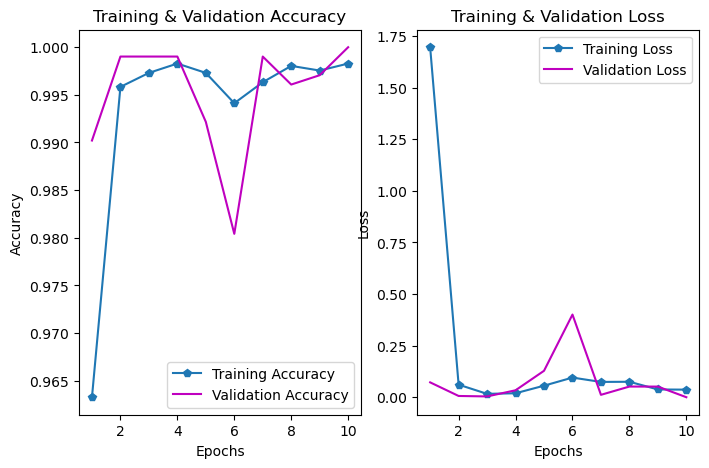

In [15]:
# Assuming you have already trained your model and have the `history` object
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(8, 5)

# Extract training and validation accuracy from the history object
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot training and validation accuracy with purple markers and solid line
ax[0].plot(epochs, train_acc, 'p-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'm-', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

# Extract training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation loss with purple markers and solid line
ax[1].plot(epochs, train_loss, 'p-', label='Training Loss')
ax[1].plot(epochs, val_loss, 'm-', label='Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()


In [16]:
# Evaluate the model on the test data
accuracy = model.evaluate(X_test, y_test_onehot)[1]  # Index 1 corresponds to accuracy
print("Accuracy of the model is:", accuracy * 100, "%")

# You can also calculate other evaluation metrics, such as precision, recall, and F1-score.
from sklearn.metrics import classification_report

# Get model predictions
y_pred = model.predict(X_test)

# Convert one-hot encoded labels back to class labels
y_test_class = label_encoder.inverse_transform(np.argmax(y_test_onehot, axis=1))
y_pred_class = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))

cohen_kappa = cohen_kappa_score(y_test_class, y_pred_class)

# Generate a classification report
report = classification_report(y_test_class, y_pred_class)

print("Cohen's Kappa:", cohen_kappa)
print("Classification Report:")
print(report)


40/40 [==============================] - 168s 4s/step - loss: 0.1783 - accuracy: 0.9914
Accuracy of the model is: 99.13793206214905 %
40/40 [==============================] - 170s 4s/step
Cohen's Kappa: 0.9827449707662728
Classification Report:
                precision    recall  f1-score   support

          APAL       0.98      1.00      0.99       652
Pseudodiploria       1.00      0.98      0.99       624

      accuracy                           0.99      1276
     macro avg       0.99      0.99      0.99      1276
  weighted avg       0.99      0.99      0.99      1276



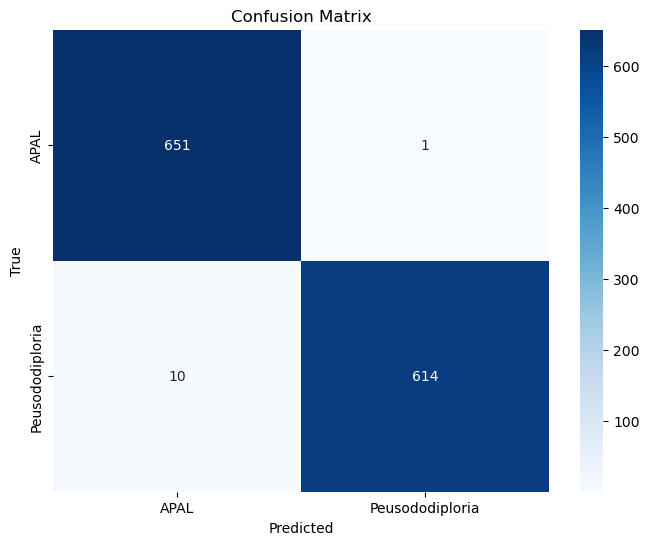

In [18]:
# Define class labels (replace these with your actual class labels)
class_labels = ['APAL', 'Peusododiploria']

cm = confusion_matrix(y_test_class, y_pred_class)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

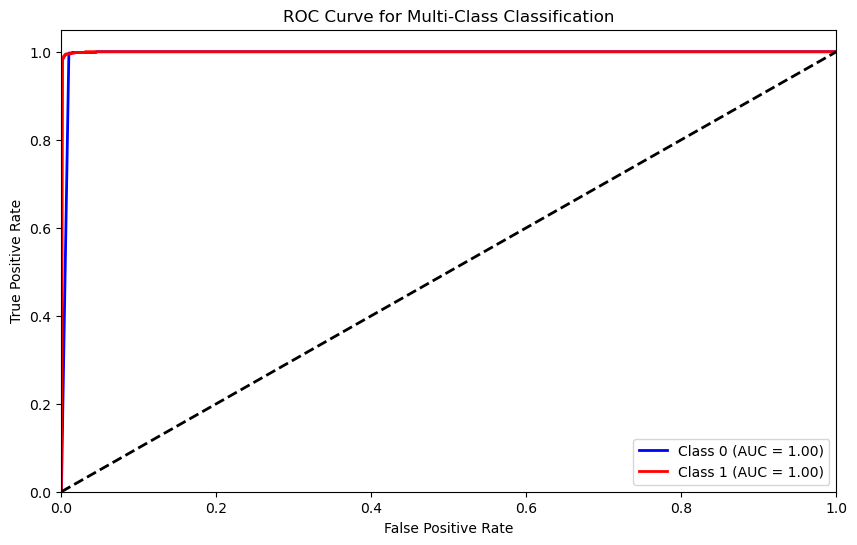

In [19]:
# Assuming you have `y_test_encoded` and `y_pred` from your code
n_classes = 2  # Number of classes

fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate the ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))
colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc='best')
plt.show()


### Changing 1 layer

In [76]:
# Load the VGG16 model pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add your own fully connected layers for classification
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)  # Add your desired number of neurons
output = Dense(num_classes, activation='softmax')(x)  # num_classes is the number of classes in your data

# Create a new model with your layers on top of the VGG16 base
model = Model(inputs=base_model.input, outputs=output)

# You can choose a different optimizer and loss function depending on your specific problem.
# Optionally, you can unfreeze some layers in the base_model and fine-tune the network.
# For example, you can unfreeze the last few convolutional layers and recompile the model.
for layer in base_model.layers[-1:]:
    layer.trainable = True

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Now, you can train your model using your augmented and normalized data
history = model.fit(X_train, y_train_onehot, validation_data=(X_valid, y_valid_onehot), epochs=10, batch_size=32)  # You can adjust the number of epochs and batch size


Epoch 1/10
160/160 [==============================] - 868s 5s/step - loss: 2.4780 - accuracy: 0.9592 - val_loss: 0.0897 - val_accuracy: 0.9851
Epoch 2/10
160/160 [==============================] - 870s 5s/step - loss: 0.0975 - accuracy: 0.9886 - val_loss: 0.0452 - val_accuracy: 0.9882
Epoch 3/10
160/160 [==============================] - 875s 5s/step - loss: 9.0706e-04 - accuracy: 1.0000 - val_loss: 0.0513 - val_accuracy: 0.9914
Epoch 4/10
160/160 [==============================] - 875s 5s/step - loss: 0.0305 - accuracy: 0.9953 - val_loss: 0.1059 - val_accuracy: 0.9875
Epoch 5/10
160/160 [==============================] - 855s 5s/step - loss: 0.0043 - accuracy: 0.9998 - val_loss: 0.0369 - val_accuracy: 0.9937
Epoch 6/10
160/160 [==============================] - 1191s 7s/step - loss: 0.1893 - accuracy: 0.9943 - val_loss: 1.9070 - val_accuracy: 0.9757
Epoch 7/10
160/160 [==============================] - 846s 5s/step - loss: 0.2089 - accuracy: 0.9943 - val_loss: 0.9341 - val_accuracy: 0

In [77]:
model.save('../models/coral_vgg16_layer01.h5')

In [39]:
# Assuming you have already trained your model and have the `history` object
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(8, 5)

# Extract training and validation accuracy from the history object
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot training and validation accuracy with purple markers and solid line
ax[0].plot(epochs, train_acc, 'p-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'm-', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy(One layer)')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

# Extract training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation loss with purple markers and solid line
ax[1].plot(epochs, train_loss, 'p-', label='Training Loss')
ax[1].plot(epochs, val_loss, 'm-', label='Validation Loss')
ax[1].set_title('Training & Validation Loss(One layer)')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()


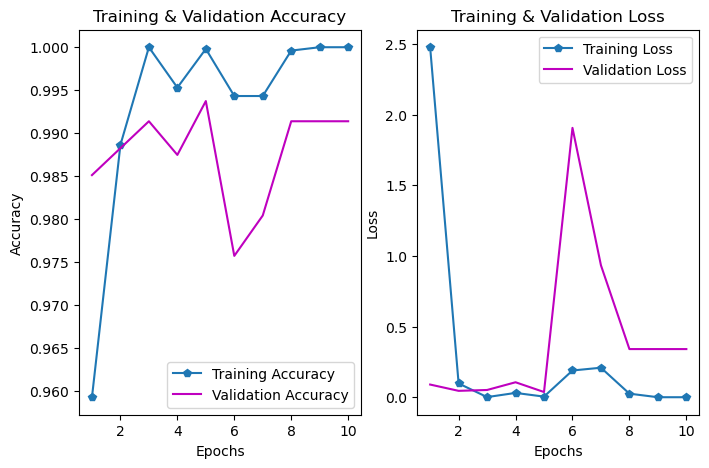

In [89]:
# Evaluate the model on the test data
accuracy = model.evaluate(X_test, y_test_onehot)[1]  # Index 1 corresponds to accuracy
print("Accuracy of the model(One layer) is:", accuracy * 100, "%")

# You can also calculate other evaluation metrics, such as precision, recall, and F1-score.
from sklearn.metrics import classification_report

# Get model predictions
y_pred = model.predict(X_test)

# Convert one-hot encoded labels back to class labels
y_test_class = label_encoder.inverse_transform(np.argmax(y_test_onehot, axis=1))
y_pred_class = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))

cohen_kappa = cohen_kappa_score(y_test_class, y_pred_class)

# Generate a classification report
report = classification_report(y_test_class, y_pred_class)

print("Cohen's Kappa(One layer):", cohen_kappa)
print("Classification Report(One layer):")
print(report)


In [79]:
cm = confusion_matrix(y_test_class, y_pred_class)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix(One layer)')
plt.show()


40/40 [==============================] - 170s 4s/step - loss: 0.3408 - accuracy: 0.9914
Accuracy of the model is: 99.13793206214905 %
40/40 [==============================] - 165s 4s/step
Classification Report:
                precision    recall  f1-score   support

          APAL       0.98      1.00      0.99       652
Pseudodiploria       1.00      0.98      0.99       624

      accuracy                           0.99      1276
     macro avg       0.99      0.99      0.99      1276
  weighted avg       0.99      0.99      0.99      1276



In [80]:
# Assuming you have `y_test_encoded` and `y_pred` from your code
n_classes = 2  # Number of classes

fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate the ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))
colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification(One layer)')
plt.legend(loc='best')
plt.show()


Cohen's Kappa: 0.9827437827949269


### Changing two layer's

In [90]:
# Load the VGG16 model pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add your own fully connected layers for classification
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)  # Add your desired number of neurons
output = Dense(num_classes, activation='softmax')(x)  # num_classes is the number of classes in your data

# Create a new model with your layers on top of the VGG16 base
model = Model(inputs=base_model.input, outputs=output)

# You can choose a different optimizer and loss function depending on your specific problem.
# Optionally, you can unfreeze some layers in the base_model and fine-tune the network.
# For example, you can unfreeze the last few convolutional layers and recompile the model.
for layer in base_model.layers[-2:]:
    layer.trainable = True

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Now, you can train your model using your augmented and normalized data
history = model.fit(X_train, y_train_onehot, validation_data=(X_valid, y_valid_onehot), epochs=10, batch_size=32)  # You can adjust the number of epochs and batch size


Epoch 1/10
160/160 [==============================] - 839s 5s/step - loss: 1.2847 - accuracy: 0.9743 - val_loss: 0.5682 - val_accuracy: 0.9749
Epoch 2/10
160/160 [==============================] - 824s 5s/step - loss: 0.1384 - accuracy: 0.9916 - val_loss: 0.7864 - val_accuracy: 0.9765
Epoch 3/10
160/160 [==============================] - 821s 5s/step - loss: 0.2108 - accuracy: 0.9939 - val_loss: 0.8790 - val_accuracy: 0.9773
Epoch 4/10
160/160 [==============================] - 849s 5s/step - loss: 0.0428 - accuracy: 0.9973 - val_loss: 0.7043 - val_accuracy: 0.9843
Epoch 5/10
160/160 [==============================] - 836s 5s/step - loss: 0.0209 - accuracy: 0.9988 - val_loss: 0.1937 - val_accuracy: 0.9914
Epoch 6/10
160/160 [==============================] - 840s 5s/step - loss: 0.0103 - accuracy: 0.9988 - val_loss: 0.3918 - val_accuracy: 0.9890
Epoch 7/10
160/160 [==============================] - 824s 5s/step - loss: 0.0465 - accuracy: 0.9984 - val_loss: 0.5162 - val_accuracy: 0.9851

In [91]:
model.save('../models/coral_vgg16_layer02.h5')

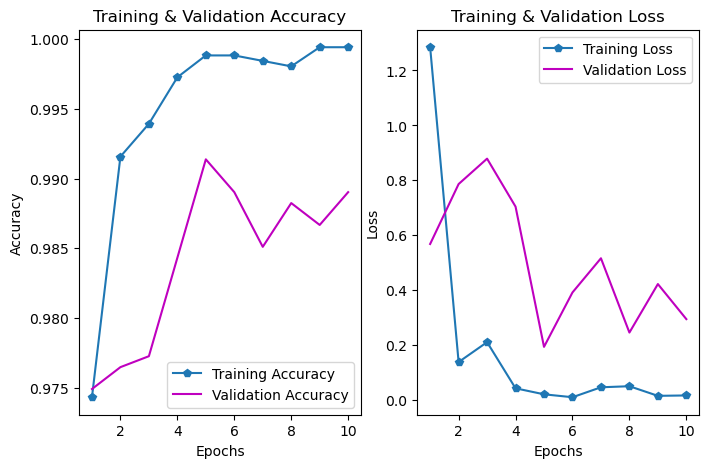

In [92]:
# Assuming you have already trained your model and have the `history` object
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(8, 5)

# Extract training and validation accuracy from the history object
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot training and validation accuracy with purple markers and solid line
ax[0].plot(epochs, train_acc, 'p-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'm-', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy(one layer)')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

# Extract training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation loss with purple markers and solid line
ax[1].plot(epochs, train_loss, 'p-', label='Training Loss')
ax[1].plot(epochs, val_loss, 'm-', label='Validation Loss')
ax[1].set_title('Training & Validation Loss(Two layers)')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()


In [93]:
# Evaluate the model on the test data
accuracy = model.evaluate(X_test, y_test_onehot)[1]  # Index 1 corresponds to accuracy
print("Accuracy of the model(Two layers) is:", accuracy * 100, "%")

# You can also calculate other evaluation metrics, such as precision, recall, and F1-score.
from sklearn.metrics import classification_report

# Get model predictions
y_pred = model.predict(X_test)

# Convert one-hot encoded labels back to class labels
y_test_class = label_encoder.inverse_transform(np.argmax(y_test_onehot, axis=1))
y_pred_class = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))

cohen_kappa = cohen_kappa_score(y_test_class, y_pred_class)

# Generate a classification report
report = classification_report(y_test_class, y_pred_class)

print("Cohen's Kappa(Two layers):", cohen_kappa)
print("Classification Report(Two layers):")
print(report)


40/40 [==============================] - 167s 4s/step - loss: 0.2946 - accuracy: 0.9890
Accuracy of the model is: 98.90282154083252 %
40/40 [==============================] - 163s 4s/step
Cohen's Kappa: 0.9780382977467864
Classification Report:
                precision    recall  f1-score   support

          APAL       0.98      1.00      0.99       652
Pseudodiploria       1.00      0.98      0.99       624

      accuracy                           0.99      1276
     macro avg       0.99      0.99      0.99      1276
  weighted avg       0.99      0.99      0.99      1276



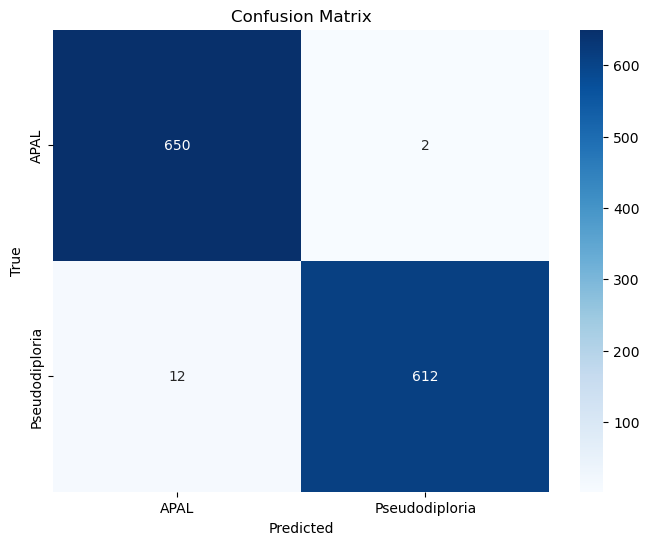

In [94]:
cm = confusion_matrix(y_test_class, y_pred_class)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix(Two Layers)')
plt.show()


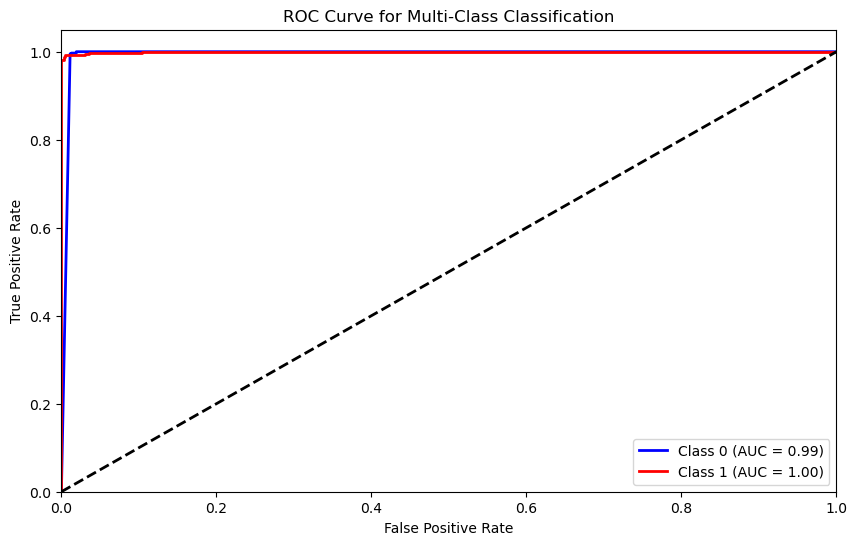

In [95]:
# Assuming you have `y_test_encoded` and `y_pred` from your code
n_classes = 2  # Number of classes

fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate the ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))
colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification(Two layers)')
plt.legend(loc='best')
plt.show()
